In [14]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import cftime

In [28]:
file_dir = '/glade/u/home/marielj/clm_frost/cesm_cases/stored-data/'
save_dir = '/glade/u/home/marielj/clm_frost/data-analysis/figures/tuning/'

#Find all case directories
dirs = glob.glob(file_dir + '*', recursive = True)

#Strip the string to get case name
case_names = [string[55:] for string in dirs]

#Spinup grass cases
spinup_grass_cases = [case for case in case_names if '_spinup_grass_' in case]
spinup_control_grass = [case for case in spinup_grass_cases if 'CONTROL' in case][0]
spinup_grass_cases.remove(spinup_control_grass)
case_names2 = [case for case in case_names if case not in spinup_grass_cases]
case_names2.remove(spinup_control_grass)

#Spinup cases
spinup_cases = [case for case in case_names2 if '_spinup_' in case]
spinup_control = [case for case in spinup_cases if 'CONTROL' in case][0]
spinup_cases.remove(spinup_control)
    
#Non Spinup cases
nospinup_cases = [case for case in case_names2 if '_nospinup_' in case]
nospinup_control = [case for case in nospinup_cases if 'CONTROL' in case][0]
nospinup_cases.remove(nospinup_control)

In [29]:
'''Universal variables'''
#Tuning values
param_values = {'SLOPEBETA': [-100, -50, -3, 1, 10],
                'SLOPEMAX': [0.2, 0.3, 0.4, 0.6, 0.8],
                'QDRAIPERCHMAX': [1e-8, 1e-7, 1e-6, 1e-4, 1e-2, 1, 10],
                'BASEFLOW': [10e-8, 10e-7, 10e-6, 10e-4, 10e-2, 1, 2], 
                'FOVER': [0.1, 0.25, 0.5, 0.75, 1, 3, 5], 
                'FMAX' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 
                'PCT_CLAY':[0, 5, 10, 20, 30], 
                'PCT_SAND':[0, 5, 10, 20, 30], 
                'SLATOP':[0.004, 0.008, 0.016, 0.032, 0.04],
                'FROOTLEAF':[0.015, 0.5, 1.0, 1.5, 2.0], 
                'LEAFLONG':[0.32, 0.74, 1.0, 1.5, 2.0]
               }

#Year for calibration
year = 2012

In [24]:
'''Universal functions'''

def import_tuningcases(param, case_names, spinup):
    #Parameter can be one of 'BASEFLOW', 'SLOPEBETA', 'QDRAIPERCHMAX'
    #case_names is the list of either spinup or nonspinup cases
    #spinup is a string of either 'spinup' or 'nospinup'
    
    
    #filter out param cases
    param_cases = [case for case in case_names if param in case]
    param_datasets = []

    #loop through values and import the data, concatenating together
    for case in np.sort(param_cases):
        #pull tuning instance
        tuning_i = case[-1]

        #param file format
        param_file_format = 'mbp_tuning_' + spinup + '_' + param + '_v' + str(tuning_i) + '.clm2.h1.' + str(year) + '-01-01-00000.nc'
        param_file_dir = file_dir + case + '/'

        #load dataset
        dataset = xr.load_dataset(param_file_dir + param_file_format)

        #add variable for tuning instance
        dataset = dataset.assign_coords(case = int(tuning_i))

        #append to list
        param_datasets.append(dataset)
        
    return param_datasets

def plot_tuning(param_datasets, tuning_var, data_var):
    fig, axs = plt.subplots(nrows= len(param_datasets), ncols=1,
                        sharex = True,
                        figsize = (6,8))

    # loop through axes
    for i in range(0, len(param_datasets)):
        data = param_datasets[i]

        #plot
        axs[i].plot(data.time, data[data_var])

        #plot formatting
        #start = cftime.DatetimeNoLeap(2012, 1, 1, 0, 0, 0, 0, has_year_zero=True)
        axs[i].set_ylabel(r'$\beta$ = ' + str(param_values[tuning_var][i]))
        #axs[i].set_ylim(0, 9)

    axs[0].set_title(data[data_var].long_name)

    plt.show()
    
def plot_tuning_means(p, v, cases, spinup):
    #feed in list of cases and parameters of interest, list of cases, nospinup/spinup
    fig, axs = plt.subplots(nrows= 2, ncols = 5,
                            #sharey = True,
                            figsize = (10, 4), 
                           constrained_layout = True)


    for i in range(0, len(p)):
        #Find cases 
        param = p[i]
        p_cases = import_tuningcases(param, cases, spinup)

        #For each case, find the annual average of the variable of interest
        means = []
        sds = []
        for j in range(0, len(p_cases)):
            means.append(float(np.mean(p_cases[j][v])))
            sds.append(float(np.std(p_cases[j][v])))

        #plot
        axs[int(np.floor(i/5))][i%5].plot(param_values[param], means)

        #error
        ub = [a + b for a, b in zip(means, sds)]
        lb = [a - b for a, b in zip(means, sds)]
        axs[int(np.floor(i/5))][i%5].fill_between(param_values[param], ub, lb, alpha = 0.3)

        #plot formatting
        axs[int(np.floor(i/5))][i%5].set_title(param)
        axs[int(np.floor(i/5))][i%5].set_xlim(min(param_values[param]), max(param_values[param]))
        #axs[i].set_xscale("log")
    
    plt.suptitle(p_cases[0][v].long_name)
    plt.savefig(save_dir + str(spinup) + str(v) + '.pdf', bbox_inches = 'tight')
    plt.savefig(save_dir + str(spinup) + str(v) + '.jpeg', bbox_inches = 'tight')
    plt.show()



### NON spinup Cases

In [5]:
'''Upload Control Case'''
#Navigate to directory and import netcdf file
control_file_dir = file_dir + nospinup_control + '/'
control_file_format = 'mbp_tuning_nospinup_CONTROL_v0.clm2.h1.' + str(year) + '-01-01-00000.nc'

control = xr.load_dataset(control_file_dir + control_file_format)

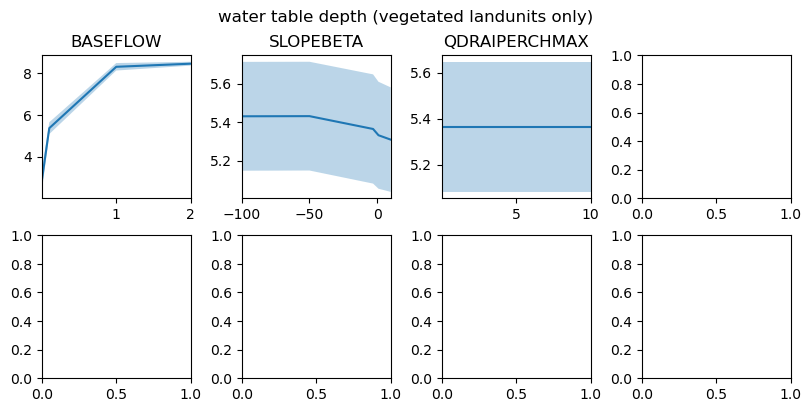

In [6]:
plot_tuning_means(['BASEFLOW', 'SLOPEBETA', 'QDRAIPERCHMAX'], 'ZWT', nospinup_cases, 'nospinup')

### Surface files experiments

In [7]:
'''ARCTIC GRASS'''

dataset_grass = xr.load_dataset(file_dir + 
                          'mbp_tuning_nospinup_ARCTICGRASS_v0/mbp_tuning_nospinup_ARCTICGRASS_v0.clm2.h1.2012-01-01-00000.nc')

NameError: name 'dataset' is not defined

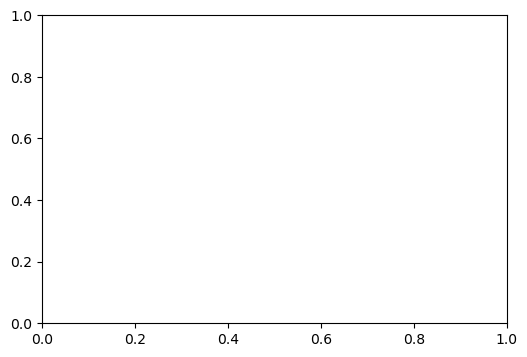

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ARCTIC GRASS water table
axs.plot(dataset.time, dataset.ZWT_PERCH, label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT_PERCH, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Perched Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ARCTIC GRASS water table
axs.plot(dataset.time, dataset.QRUNOFF, label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.QRUNOFF, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Total Runoff [mm/s]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ARCTIC GRASS water table
axs.plot(dataset.time, dataset.ZWT, label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
'''SILT SOIL'''

dataset_silt = xr.load_dataset(file_dir + 
                          'mbp_tuning_nospinup_ORGANIC_v0/mbp_tuning_nospinup_ORGANIC_v0.clm2.h1.2012-01-01-00000.nc')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ORGANIC water table
axs.plot(dataset_silt.time, dataset_silt.ZWT_PERCH, label = 'Silt + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.ZWT_PERCH, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT_PERCH, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Perched Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ORGANIC water table
axs.plot(dataset_silt.time, dataset_silt.ZWT, label = 'Silt + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.ZWT, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ORGANIC water table
axs.plot(dataset_silt.time, dataset_silt.QRUNOFF, label = 'Silt + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.QRUNOFF, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.QRUNOFF, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Total Runoff [mm/s]")

plt.legend()
plt.show()

In [ ]:
'''PEATF'''

dataset_peat = xr.load_dataset(file_dir + 
                          'mbp_tuning_nospinup_ORGANIC_v0/modified-peatf/mbp_tuning_nospinup_ORGANIC_v0.clm2.h1.2012-01-01-00000.nc')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot PEATF water table
axs.plot(dataset_peat.time, dataset_peat.ZWT, label = 'Peat + Silt + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.ZWT, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ORGANIC water table
axs.plot(dataset_peat.time, dataset_peat.QRUNOFF, label = 'Peat + Silt + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.QRUNOFF, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.QRUNOFF, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Total Runoff [mm/s]")

plt.legend()
plt.show()

In [ ]:
'''PEATF + ORGANIC'''

dataset_opeat = xr.load_dataset(file_dir + 
                          'mbp_tuning_nospinup_ORGANIC_v0/modified-peatf-ocontent/mbp_tuning_nospinup_ORGANIC_v0.clm2.h1.2012-01-01-00000.nc')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot PEATF water table
axs.plot(dataset_opeat.time, dataset_opeat.ZWT, label = 'OPeat + Silt + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.ZWT, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ORGANIC water table
axs.plot(dataset_opeat.time, dataset_opeat.QRUNOFF, label = 'OPeat + Silt + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.QRUNOFF, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.QRUNOFF, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Total Runoff [mm/s]")

plt.legend()
plt.show()

In [ ]:
'''PEATF + ORGANIC + SPRUCE SOIL'''

dataset_sprucepeat = xr.load_dataset(file_dir + 
                          'mbp_tuning_nospinup_ORGANIC_v0/modified-peatf-ocontent-spruce/mbp_tuning_nospinup_ORGANIC_v0.clm2.h1.2012-01-01-00000.nc')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot PEATF water table
axs.plot(dataset_sprucepeat.time, dataset_sprucepeat.ZWT, label = 'Spruce Peat + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.ZWT, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ORGANIC water table
axs.plot(dataset_sprucepeat.time, dataset_sprucepeat.QRUNOFF, label = 'Spruce Peat + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.QRUNOFF, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.QRUNOFF, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Total Runoff [mm/s]")

plt.legend()
plt.show()

In [ ]:
'''ORGANIC + SPRUCE SOIL'''

dataset_spruce = xr.load_dataset(file_dir + 
                          'mbp_tuning_nospinup_ORGANIC_v0/modified-ocontent-spruce/mbp_tuning_nospinup_ORGANIC_v0.clm2.h1.2012-01-01-00000.nc')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot PEATF water table
axs.plot(dataset_spruce.time, dataset_spruce.ZWT, label = 'Spruce + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.ZWT, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ORGANIC water table
axs.plot(dataset_spruce.time, dataset_spruce.QRUNOFF, label = 'Spruce + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.QRUNOFF, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.QRUNOFF, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Total Runoff [mm/s]")

plt.legend()
plt.show()

In [ ]:
'''ORGANIC + SPRUCE SOIL + SPRUCE PFTs'''

dataset_sprucepfts = xr.load_dataset(file_dir + 
                          'mbp_tuning_nospinup_ORGANIC_v0/modified-ocontent-spruce-pfts/mbp_tuning_nospinup_ORGANIC_v0.clm2.h1.2012-01-01-00000.nc')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot PEATF water table
axs.plot(dataset_sprucepfts.time, dataset_sprucepfts.ZWT, label = 'Spruce PFTs + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.ZWT, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.ZWT, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Water Table Depth [m]")

plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,
                        #sharex = True,
                        figsize = (6,4))

#Plot ORGANIC water table
axs.plot(dataset_sprucepfts.time, dataset_sprucepfts.QRUNOFF, label = 'Spruce PFTs + Arctic Grass')

#Plot ARCTIC GRASS water table
axs.plot(dataset_grass.time, dataset_grass.QRUNOFF, linestyle = ':', label = 'Arctic Grass')

#Plot PRIOR water table
data = param_datasets[5]
axs.plot(data.time, data.QRUNOFF, linestyle = '--', label = 'Mixed PFTs')

axs.set_title("Total Runoff [mm/s]")

plt.legend()
plt.show()

### Spinup: Organic Soils, SPRUCE mixed pfts, no peatland

Spinup and runs done using: surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_c230220_v4.nc

In [5]:
'''Upload Control Case'''
#Navigate to directory and import netcdf file
control_file_dir = file_dir + spinup_control + '/'
control_file_format = 'mbp_tuning_spinup_CONTROL_v0.clm2.h1.' + str(year) + '-01-01-00000.nc'

control = xr.load_dataset(control_file_dir + control_file_format)

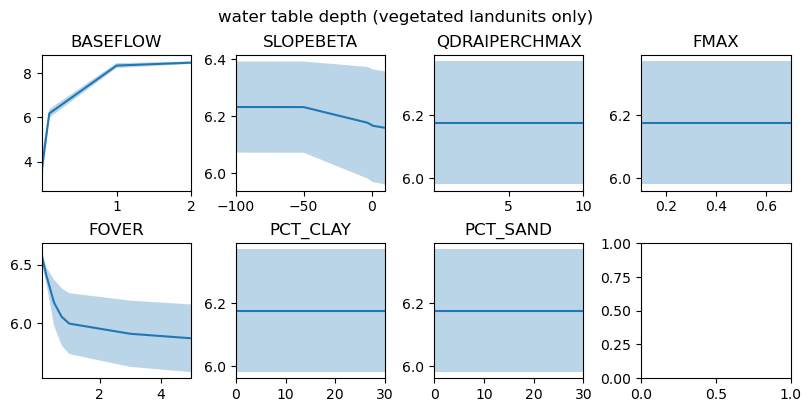

In [19]:
plot_tuning_means(['BASEFLOW', 'SLOPEBETA', 'QDRAIPERCHMAX', 'FMAX', 'FOVER', 'PCT_CLAY', 'PCT_SAND'], 'ZWT', spinup_cases, 'spinup')

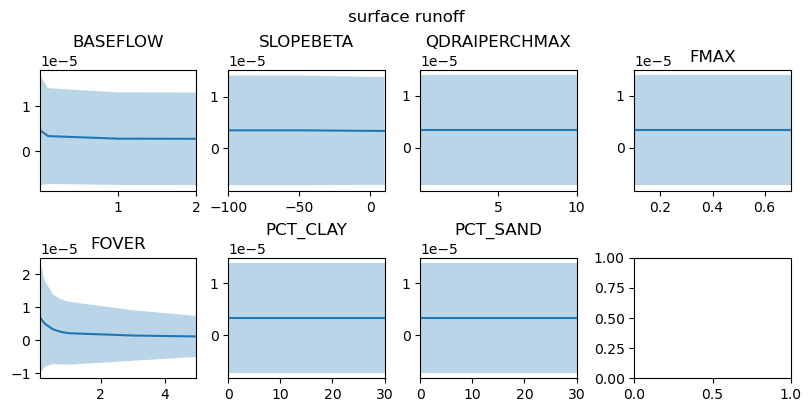

In [11]:
plot_tuning_means(['BASEFLOW', 'SLOPEBETA', 'QDRAIPERCHMAX', 'FMAX', 'FOVER', 'PCT_CLAY', 'PCT_SAND'], 'QOVER', spinup_cases, 'spinup')

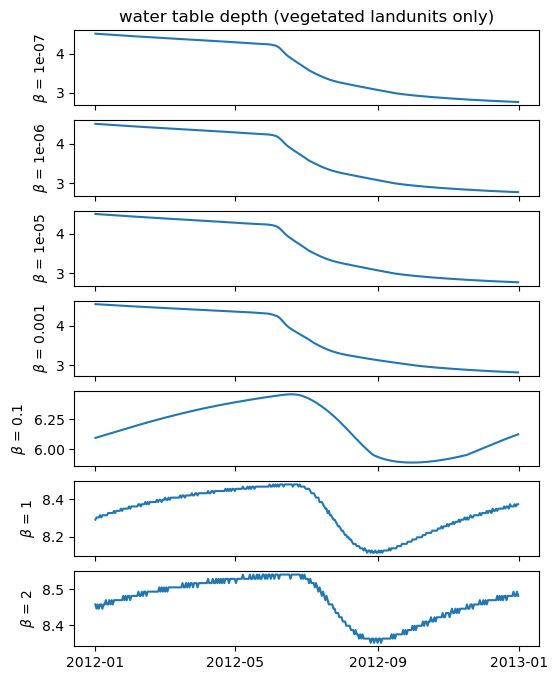

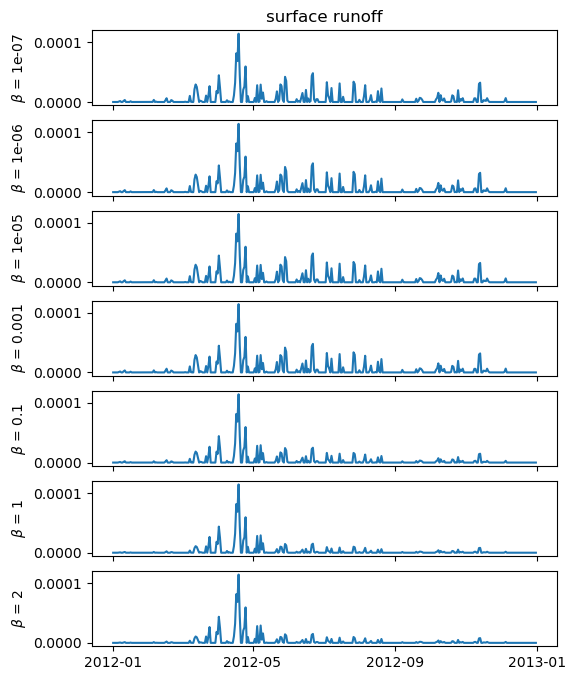

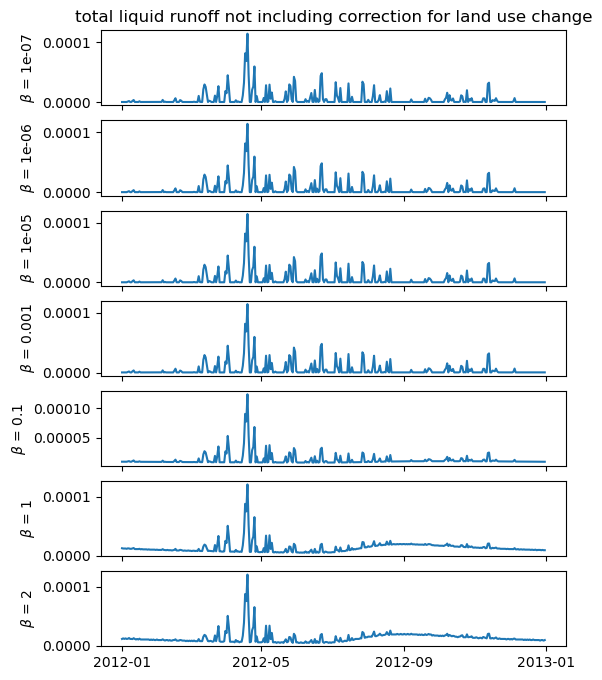

In [11]:
#BASEFLOW
baseflow_data_sp = import_tuningcases('BASEFLOW', spinup_cases, 'spinup')
# Plot water table
plot_tuning(baseflow_data_sp, 'BASEFLOW', 'ZWT')

# Plot overland runoff
plot_tuning(baseflow_data_sp, 'BASEFLOW', 'QOVER')

# Plot total runoff
plot_tuning(baseflow_data_sp, 'BASEFLOW', 'QRUNOFF')

TypeError: float() argument must be a string or a number, not 'cftime._cftime.DatetimeNoLeap'

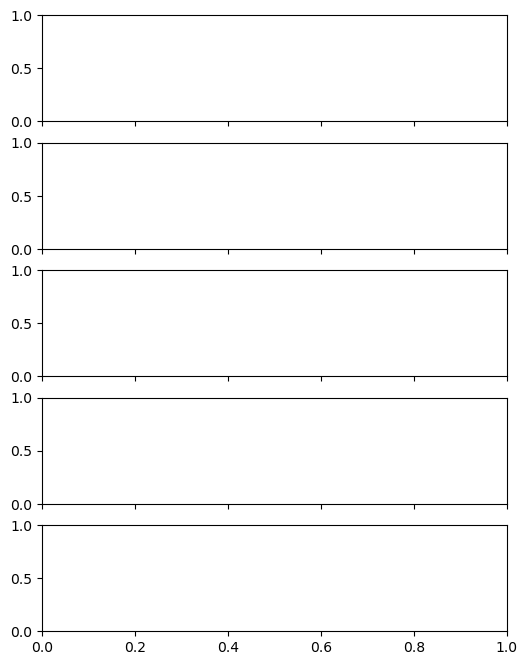

In [7]:
#SLOPEBETA
slopeb_data_sp = import_tuningcases('SLOPEBETA', spinup_cases, 'spinup')
# Plot water table
plot_tuning(slopeb_data_sp, 'SLOPEBETA', 'ZWT')

# Plot runoff
plot_tuning(slopeb_data_sp, 'SLOPEBETA', 'QOVER')

In [ ]:
#QDRAIPERCHMAX
perch_data_sp = import_tuningcases('QDRAIPERCHMAX', spinup_cases, 'spinup')
# Plot water table
plot_tuning(perch_data_sp, 'QDRAIPERCHMAX', 'ZWT')

# Plot runoff
plot_tuning(perch_data_sp, 'QDRAIPERCHMAX', 'QOVER')

In [ ]:
#FMAX
fmax_data_sp = import_tuningcases('FMAX', spinup_cases, 'spinup')
# Plot water table
plot_tuning(fmax_data_sp, 'FMAX', 'ZWT')

# Plot runoff
plot_tuning(fmax_data_sp, 'FMAX', 'QOVER')

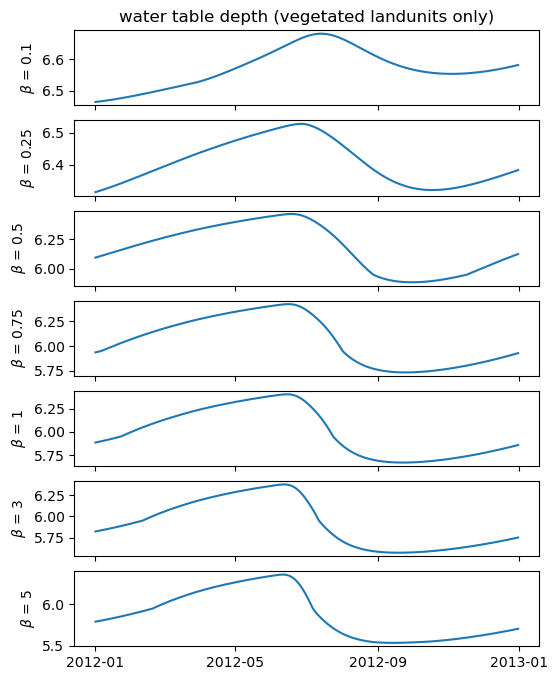

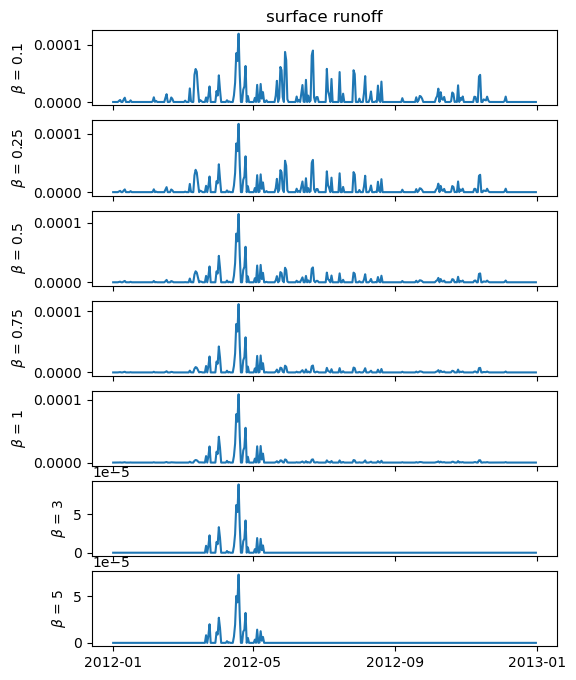

In [12]:
#FOVER
fover_data_sp = import_tuningcases('FOVER', spinup_cases, 'spinup')
# Plot water table
plot_tuning(fover_data_sp, 'FOVER', 'ZWT')

# Plot runoff
plot_tuning(fover_data_sp, 'FOVER', 'QOVER')

### Spinup: Organic Soils, Arctic Grass, no peatland

Spinup done using: surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_c230220_v3.nc

In [ ]:
'''Upload Control Case'''
#Navigate to directory and import netcdf file
control_file_dir = file_dir + spinup_control_grass + '/'
control_file_format = 'mbp_tuning_spinup_grass_CONTROL_v0.clm2.h1.' + str(year) + '-01-01-00000.nc'

control = xr.load_dataset(control_file_dir + control_file_format)

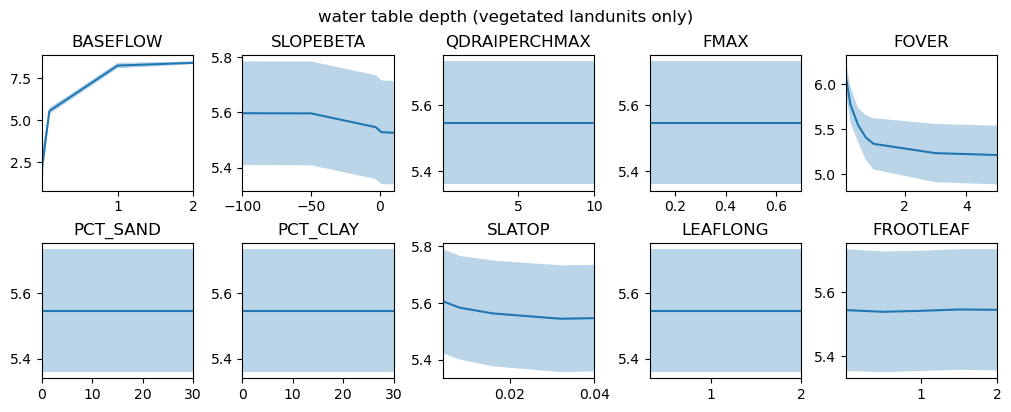

In [31]:
plot_tuning_means(['BASEFLOW', 'SLOPEBETA','QDRAIPERCHMAX', 'FMAX', 'FOVER', 'PCT_SAND', 'PCT_CLAY', 'SLATOP', 'LEAFLONG', 'FROOTLEAF'], 'ZWT', spinup_grass_cases, 'spinup_grass')

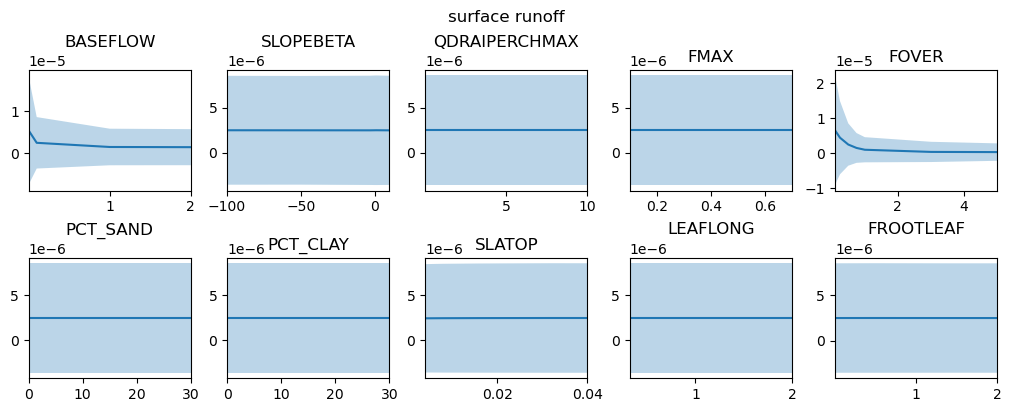

In [30]:
plot_tuning_means(['BASEFLOW', 'SLOPEBETA', 'QDRAIPERCHMAX', 'FMAX', 'FOVER', 'PCT_SAND', 'PCT_CLAY', 'SLATOP', 'LEAFLONG', 'FROOTLEAF'], 'QOVER', spinup_grass_cases, 'spinup_grass')

In [ ]:
#BASEFLOW
baseflow_data_grass = import_tuningcases('BASEFLOW', spinup_grass_cases, 'spinup_grass')
# Plot water table
plot_tuning(baseflow_data_grass, 'BASEFLOW', 'ZWT')

# Plot overland runoff
plot_tuning(baseflow_data_grass, 'BASEFLOW', 'QOVER')

# Plot total runoff
plot_tuning(baseflow_data_grass, 'BASEFLOW', 'QRUNOFF')

In [ ]:
#SLOPEBETA
slopeb_data_grass = import_tuningcases('SLOPEBETA', spinup_grass_cases, 'spinup_grass')
# Plot water table
plot_tuning(slopeb_data_grass, 'SLOPEBETA', 'ZWT')

# Plot overland runoff
plot_tuning(slopeb_data_grass, 'SLOPEBETA', 'QOVER')

In [ ]:
#QDRAIPERCHMAX
perch_data_grass = import_tuningcases('QDRAIPERCHMAX', spinup_grass_cases, 'spinup_grass')
# Plot water table
plot_tuning(perch_data_grass, 'QDRAIPERCHMAX', 'ZWT')

# Plot overland runoff
plot_tuning(perch_data_grass, 'QDRAIPERCHMAX', 'QOVER')

In [ ]:
#FMAX
fmax_data_grass = import_tuningcases('FMAX', spinup_grass_cases, 'spinup_grass')
# Plot water table
plot_tuning(fmax_data_grass, 'FMAX', 'ZWT')

# Plot overland runoff
plot_tuning(fmax_data_grass, 'FMAX', 'QOVER')

In [ ]:
#FOVER
fover_data_grass = import_tuningcases('FOVER', spinup_grass_cases, 'spinup_grass')
# Plot water table
plot_tuning(fover_data_grass, 'FOVER', 'ZWT')

# Plot overland runoff
plot_tuning(fover_data_grass, 'FOVER', 'QOVER')

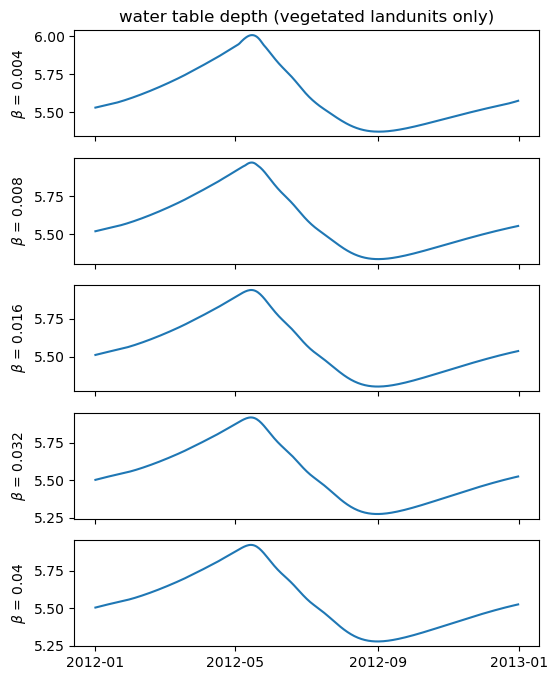

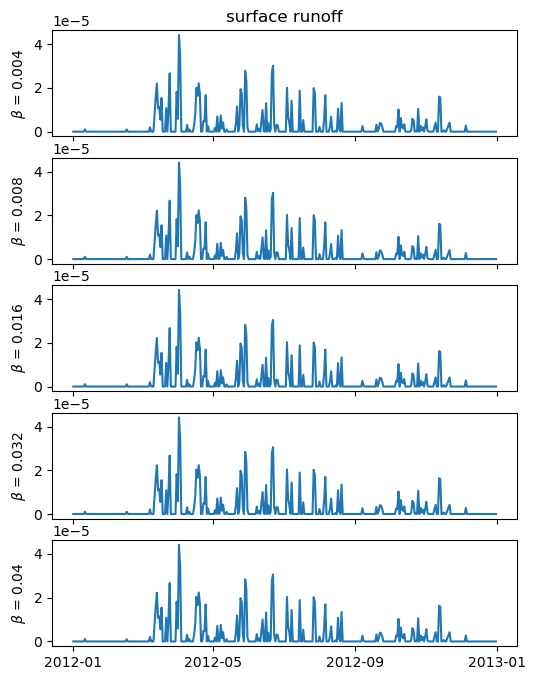

In [13]:
#SLATOP
slatop_data_grass = import_tuningcases('SLATOP', spinup_grass_cases, 'spinup_grass')
# Plot water table
plot_tuning(slatop_data_grass, 'SLATOP', 'ZWT')

# Plot overland runoff
plot_tuning(slatop_data_grass, 'SLATOP', 'QOVER')

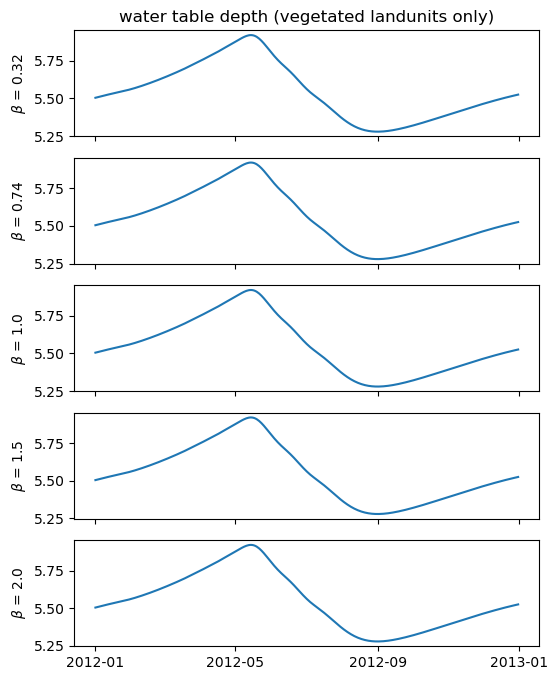

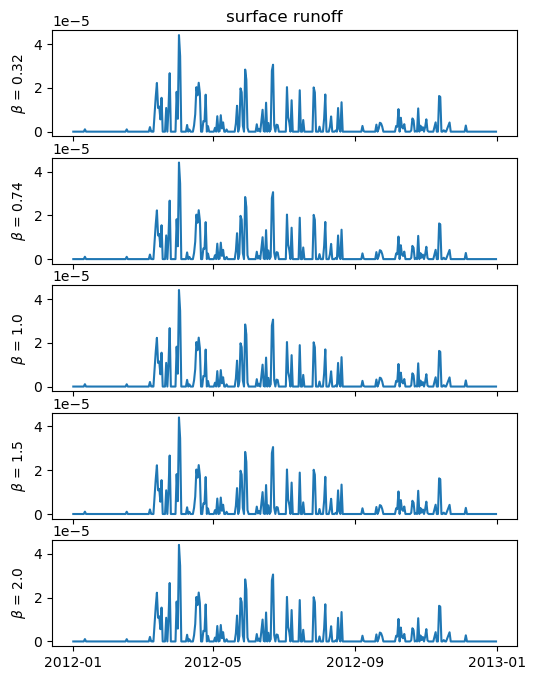

In [32]:
#LEAFLONG
leaflong_data_grass = import_tuningcases('LEAFLONG', spinup_grass_cases, 'spinup_grass')
# Plot water table
plot_tuning(leaflong_data_grass, 'LEAFLONG', 'ZWT')

# Plot overland runoff
plot_tuning(leaflong_data_grass, 'LEAFLONG', 'QOVER')

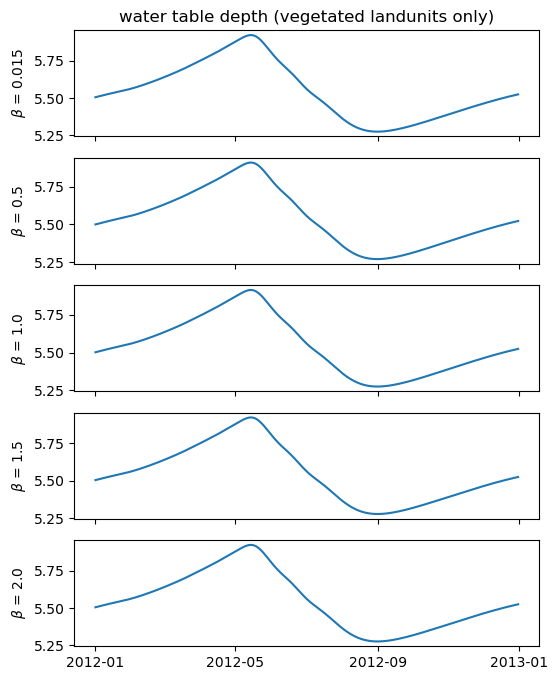

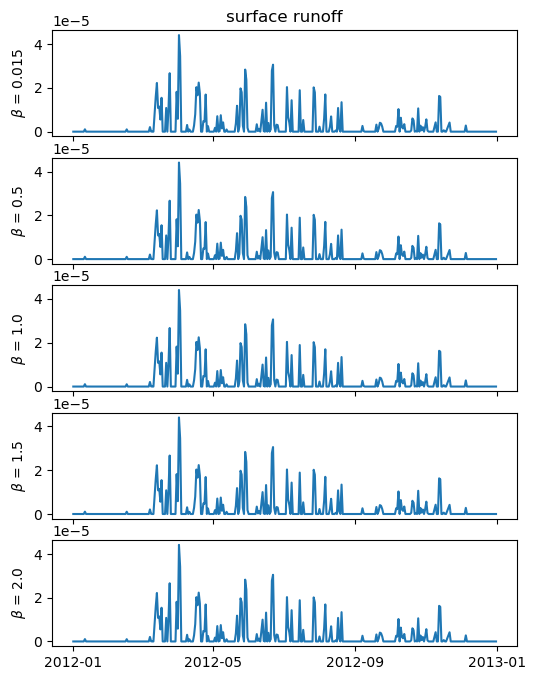

In [33]:
#FROOTLEAF
froot_data_grass = import_tuningcases('FROOTLEAF', spinup_grass_cases, 'spinup_grass')
# Plot water table
plot_tuning(froot_data_grass, 'FROOTLEAF', 'ZWT')

# Plot overland runoff
plot_tuning(froot_data_grass, 'FROOTLEAF', 'QOVER')